In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))
from utils.data_utils import load_clean_data

df = load_clean_data()


⚡ クリーンデータをキャッシュからロード


In [3]:
player_summary = (
    df.groupby("athlete_name")
      .agg(
          count=("date_", "count"),
          unique_days=("date_", lambda x: x.nunique()),
          first_date=("date_", "min"),
          last_date=("date_", "max")
      )
      .reset_index()
)

player_summary["duration_days"] = (player_summary["last_date"] - player_summary["first_date"]).dt.days + 1
player_summary["density_ratio"] = player_summary["unique_days"] / player_summary["duration_days"]

player_summary = player_summary.sort_values("count", ascending=False)
display(player_summary.head(10))


,athlete_name,count,unique_days,first_date,last_date,duration_days,density_ratio
13,Kaoru YAMAWAKI,2741,623,2023-01-12,2025-10-05,998,0.624248
42,Shoma TAKAYOSHI,2707,611,2023-01-12,2025-10-04,997,0.612839
30,Rinpei OKANO,2636,607,2023-01-12,2025-10-05,998,0.608216
19,Koki HASEGAWA,2535,603,2023-01-12,2025-10-05,998,0.604208
39,Seungjin KO,2434,595,2023-01-12,2025-10-05,998,0.596192
9,Haruki IZAWA,2337,572,2023-01-12,2025-10-05,998,0.573146
34,Ryuki HIRAHARA,2257,568,2023-01-12,2025-09-27,990,0.573737
12,Kakeru SAKAMOTO,2147,519,2023-01-12,2025-07-08,909,0.570957
27,Raiki TUBOGO,2041,527,2023-01-12,2025-10-05,998,0.528056
47,Takaya INUI,1915,448,2023-01-12,2024-11-27,686,0.653061


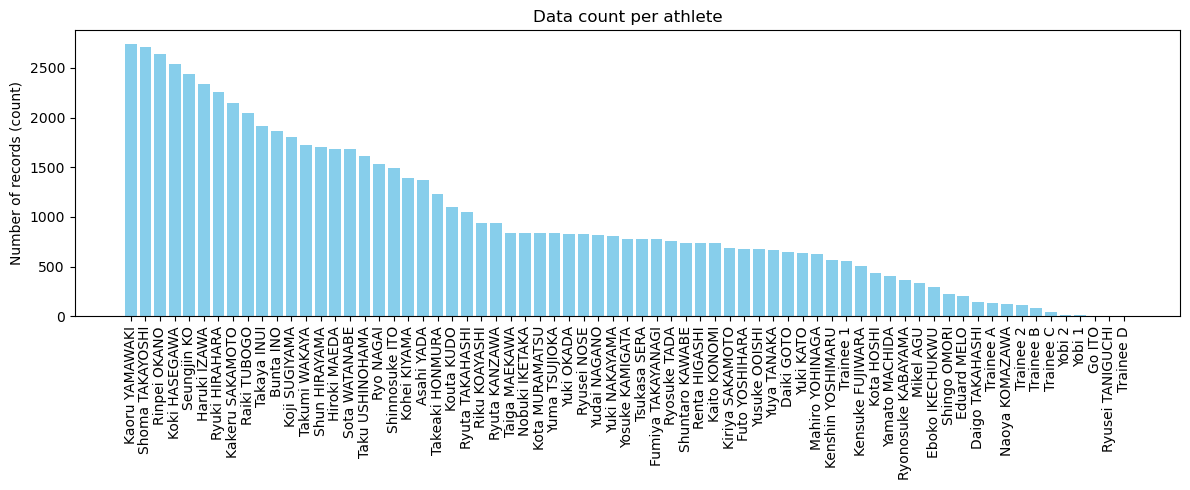

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(player_summary["athlete_name"], player_summary["count"], color="skyblue")
plt.xticks(rotation=90)
plt.ylabel("Number of records (count)")
plt.title("Data count per athlete")
plt.tight_layout()
plt.show()


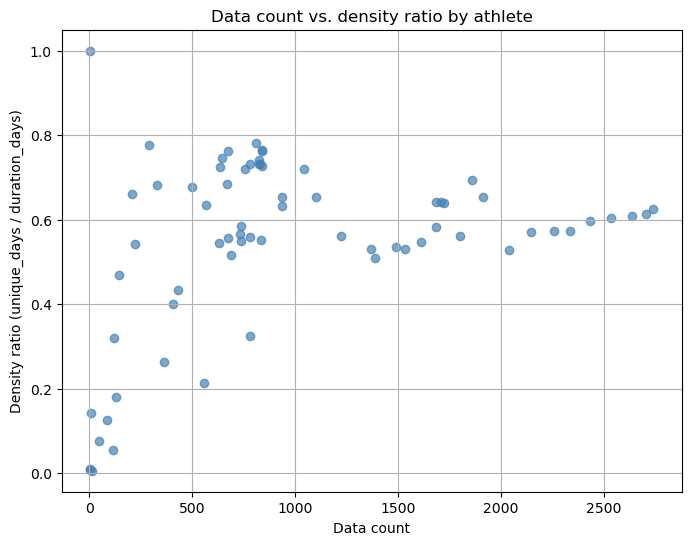

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(player_summary["count"], player_summary["density_ratio"], alpha=0.7, color="steelblue")
plt.xlabel("Data count")
plt.ylabel("Density ratio (unique_days / duration_days)")
plt.title("Data count vs. density ratio by athlete")
plt.grid(True)
plt.show()


In [6]:
# 条件を設定
cond = (player_summary["count"] >= 1000) & (player_summary["density_ratio"] >= 0.5)
highlight = player_summary[cond]
print(f"異常検知対象候補: {len(highlight)} 名")
display(highlight[["athlete_name", "count", "density_ratio"]])


異常検知対象候補: 24 名


,athlete_name,count,density_ratio
13,Kaoru YAMAWAKI,2741,0.624248
42,Shoma TAKAYOSHI,2707,0.612839
30,Rinpei OKANO,2636,0.608216
19,Koki HASEGAWA,2535,0.604208
39,Seungjin KO,2434,0.596192
9,Haruki IZAWA,2337,0.573146
34,Ryuki HIRAHARA,2257,0.573737
12,Kakeru SAKAMOTO,2147,0.570957
27,Raiki TUBOGO,2041,0.528056
47,Takaya INUI,1915,0.653061


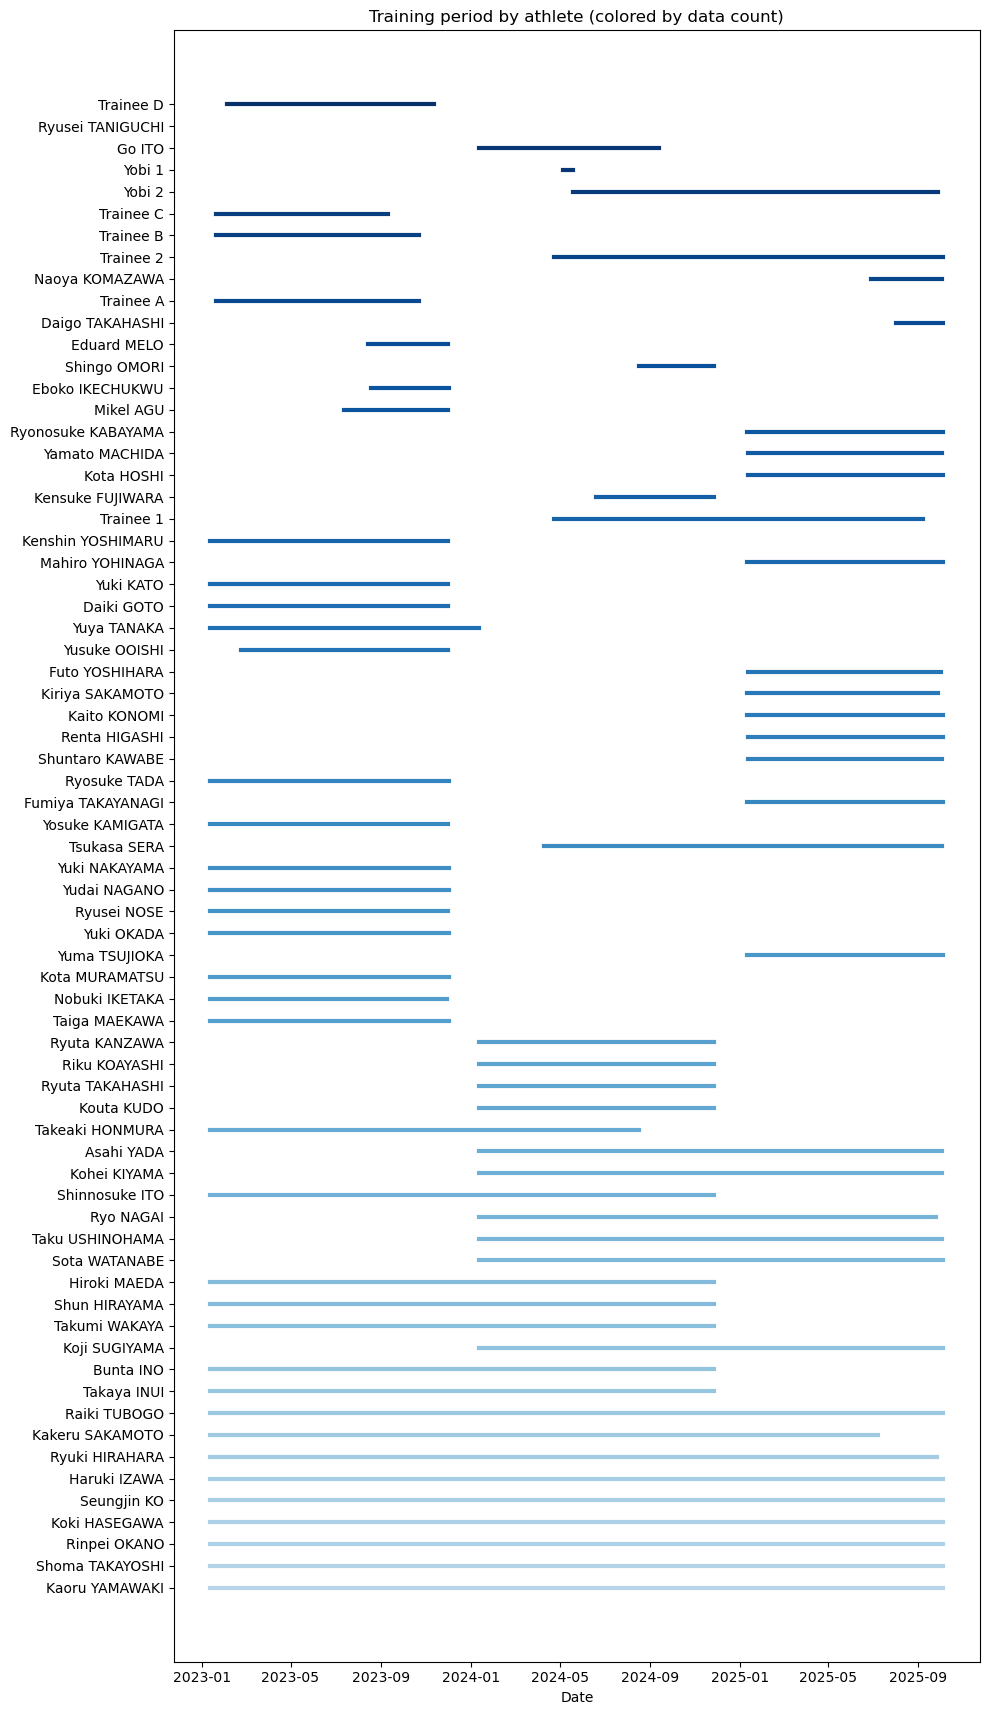

In [7]:
import matplotlib.cm as cm
import numpy as np

player_summary_sorted = player_summary.sort_values("count", ascending=False).reset_index(drop=True)
colors = cm.Blues(np.linspace(0.3, 1, len(player_summary_sorted)))

plt.figure(figsize=(10, len(player_summary_sorted)*0.25))
for i, (idx, row) in enumerate(player_summary_sorted.iterrows()):
    plt.plot([row["first_date"], row["last_date"]], [i, i],
             color=colors[i], linewidth=3)
plt.yticks(range(len(player_summary_sorted)), player_summary_sorted["athlete_name"])
plt.title("Training period by athlete (colored by data count)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [8]:
valid_players = player_summary.query("count >= 1000 and density_ratio >= 0.5")
print(f"異常検知に使えそうな選手数: {len(valid_players)}名")
display(valid_players[["athlete_name", "count", "density_ratio", "first_date", "last_date"]])


異常検知に使えそうな選手数: 24名


,athlete_name,count,density_ratio,first_date,last_date
13,Kaoru YAMAWAKI,2741,0.624248,2023-01-12,2025-10-05
42,Shoma TAKAYOSHI,2707,0.612839,2023-01-12,2025-10-04
30,Rinpei OKANO,2636,0.608216,2023-01-12,2025-10-05
19,Koki HASEGAWA,2535,0.604208,2023-01-12,2025-10-05
39,Seungjin KO,2434,0.596192,2023-01-12,2025-10-05
9,Haruki IZAWA,2337,0.573146,2023-01-12,2025-10-05
34,Ryuki HIRAHARA,2257,0.573737,2023-01-12,2025-09-27
12,Kakeru SAKAMOTO,2147,0.570957,2023-01-12,2025-07-08
27,Raiki TUBOGO,2041,0.528056,2023-01-12,2025-10-05
47,Takaya INUI,1915,0.653061,2023-01-12,2024-11-27


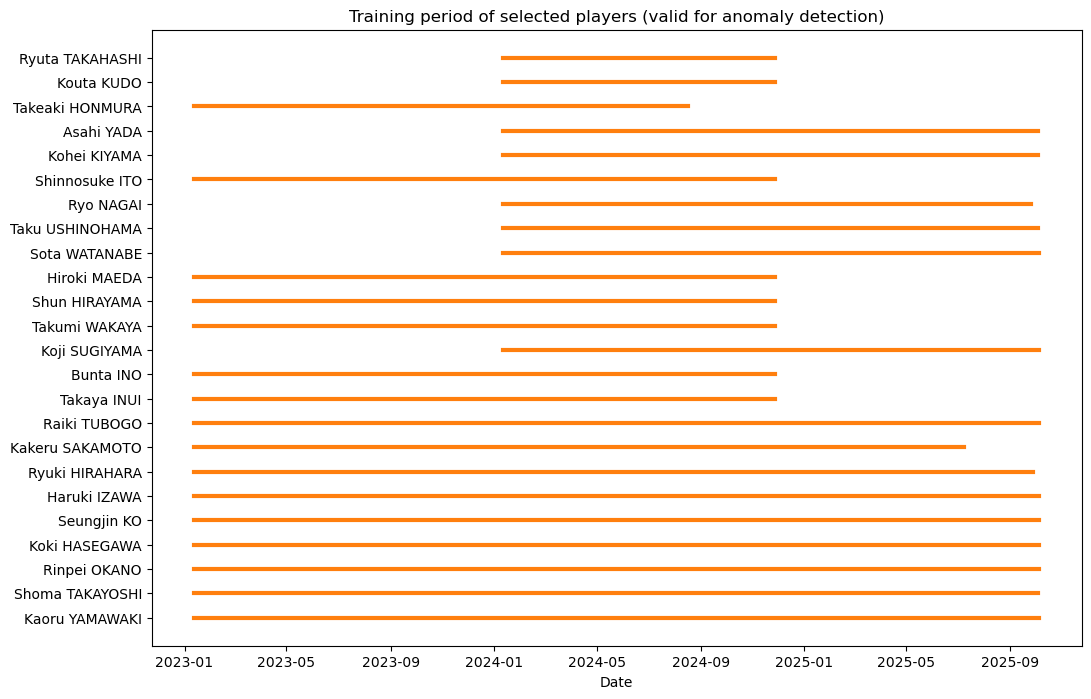

In [9]:
plt.figure(figsize=(12, 8))
for i, row in enumerate(valid_players.itertuples()):
    plt.plot([row.first_date, row.last_date], [i, i], color="tab:orange", linewidth=3)
plt.yticks(range(len(valid_players)), valid_players["athlete_name"])
plt.title("Training period of selected players (valid for anomaly detection)")
plt.xlabel("Date")
plt.show()


In [10]:
player_summary.to_csv("../data/processed/player_summary.csv", index=False)
valid_players.to_csv("../data/processed/valid_players.csv", index=False)
